This notebook reproduces some of the reulsts obtained in the following paper for calibrating neural networks https://arxiv.org/pdf/1706.04599.pdf

For a perfectly calibrated neural network we expect that the confidence should match the accuracy. For example, if we have a 100 examples and we classify each of them with 80% confidence, then the accuracy of predictions should be ~80%

$P(\hat{y} = y | \hat{p} = p ) = p$, where $p$ is the confidence. 


In [1]:
import os
import sys
from datetime import datetime

import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from tqdm import tqdm

%matplotlib inline

Using TensorFlow backend.


In [2]:
"""
Collect data
"""

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train / 255.
x_test = x_test / 255.

one_hot_y_train = keras.utils.to_categorical(y_train, 10)
one_hot_y_test = keras.utils.to_categorical(y_test, 10)

print(x_train.shape, one_hot_y_train.shape, x_test.shape, one_hot_y_test.shape)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In [7]:
# define a sequential Lenet model
lenet = keras.Sequential()
lenet.add(keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(32,32,3), padding='same'))
lenet.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
lenet.add(keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
lenet.add(keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
lenet.add(keras.layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
lenet.add(keras.layers.Flatten())
lenet.add(keras.layers.Dense(84, activation='tanh'))
lenet.add(keras.layers.Dense(10, activation='softmax'))
lenet.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])
print(lenet.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 6)         456       
_________________________________________________________________
average_pooling2d_3 (Average (None, 31, 31, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 16)        2416      
_________________________________________________________________
average_pooling2d_4 (Average (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 9, 120)         48120     
_________________________________________________________________
flatten_2 (Flatten)          (None, 9720)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 84)               

In [10]:
lenet.fit(x_train, one_hot_y_train, batch_size=32, epochs=30)

Epoch 1/30
50000/50000 [==============================] - 15s 305us/step - loss: 0.3668 - acc: 0.8917
Epoch 2/30
50000/50000 [==============================] - 15s 307us/step - loss: 0.3342 - acc: 0.9055
Epoch 3/30
50000/50000 [==============================] - 15s 306us/step - loss: 0.3011 - acc: 0.9172
Epoch 4/30
50000/50000 [==============================] - 15s 308us/step - loss: 0.2674 - acc: 0.9318
Epoch 5/30
50000/50000 [==============================] - 15s 305us/step - loss: 0.2359 - acc: 0.9444
Epoch 6/30
50000/50000 [==============================] - 15s 306us/step - loss: 0.2082 - acc: 0.9549
Epoch 7/30
50000/50000 [==============================] - 15s 306us/step - loss: 0.1827 - acc: 0.9654
Epoch 8/30
50000/50000 [==============================] - 16s 312us/step - loss: 0.1584 - acc: 0.9736
Epoch 9/30
50000/50000 [==============================] - 15s 308us/step - loss: 0.1353 - acc: 0.9805
Epoch 10/30
50000/50000 [==============================] - 15s 305us/step - loss: 

KeyboardInterrupt: ignored

In [11]:
lenet_predictions = lenet.predict(x_test)
lenet_score = lenet.evaluate(x_test, one_hot_y_test)
print(lenet_score)

10000/10000 [==============================] - 1s 121us/step
[1.6591233617782593, 0.591]


In [14]:
lenet_predictions.shape

(10000, 10)

In [20]:
# Create a dataframe with the predictions and the ground truth values
df = pd.DataFrame()
class_prediction = np.argmax(lenet_predictions, axis=1)
class_confidence = np.max(lenet_predictions, axis=1)
print("Min-max confidence: ", np.min(class_confidence), np.max(class_confidence))
df['predictions'] = class_prediction
df['gt'] = y_test
df['scores'] = class_confidence
df['correct'] = df['gt'] == df['predictions']
df.head()

Min-max confidence:  0.2134445 1.0


,predictions,gt,scores,correct
0,3,3,0.975125,True
1,1,8,0.875034,False
2,8,8,0.925611,True
3,0,0,0.917477,True
4,4,6,0.976642,False


In [50]:
i = 0.5
min_conf = i
max_conf = i+0.1
temp_df = df.loc[(df.scores >= min_conf) & (df.scores < max_conf)]
fc, tc = temp_df.correct.value_counts().sort_index().tolist()
print(df.correct.value_counts())
print(fc, tc)
print(tc / (tc + fc))
print(len(temp_df))

True     5910
False    4090
Name: correct, dtype: int64
617 346
0.3592938733125649
963


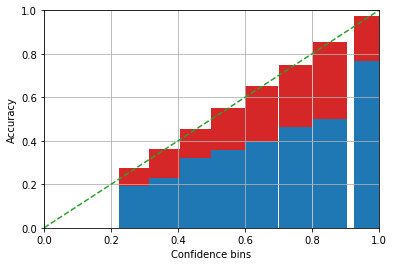

In [74]:
ret = plot_miscalibration(df)


In [59]:
print(np.sum(ret[:, 3])/ len(y_test)) 

0.2305009536653757


In [0]:

def plot_miscalibration(df):
    bins = np.linspace(0,1,11)[:-1]
    ret = []
    for i in bins:
        min_conf = i
        max_conf = i+0.1
        temp_df = df.loc[(df.scores >= min_conf) & (df.scores < max_conf)]
        n_samples = len(temp_df)
        if n_samples > 0:
            bin_conf = temp_df.scores.mean()
            fc, tc = temp_df.correct.value_counts().sort_index().tolist()
            bin_acc = tc / n_samples
        else:
            bin_conf = 0
            bin_acc = 0
        bin_error = np.abs(bin_conf - bin_acc)
        weighted_bin_error = n_samples * bin_error
        ret.append([bin_conf, bin_acc, bin_error, weighted_bin_error, n_samples])
    ret =  np.array(ret)
    plt.bar(ret[:,0], ret[:,1] + ret[:,2], width=0.1, color='C3')
    plt.bar(ret[:,0], ret[:,1], width=0.1, color='C0')
    plt.plot([0,1],'--C2')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('Confidence bins')
    plt.ylabel('Accuracy')
    plt.grid()
    return ret

Min-max confidence:  0.26938424 1.0
0.27895716 0.3333333333333333
0.36445746 0.13513513513513514
0.46214193 0.3474576271186441
0.54844326 0.3271276595744681
0.64787436 0.38786279683377306
0.7505153 0.3844282238442822
0.8537652 0.45151033386327505
0.99164075 0.8091214117062259
ECE:  0.028122764123180037


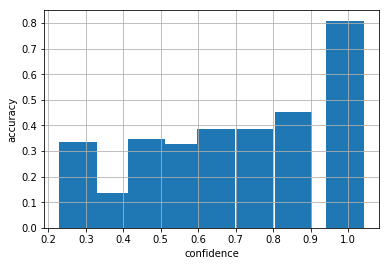

In [0]:
ECE = plot_discrepancy(lenet_predictions, y_test)
np.save('lenet_predictions', lenet_predictions)
print("ECE: ", ECE)

In [0]:
"""
Define a function that accepts predictions and ground truths, then plots the 
confidence vs. accuracy. This plot is also known as a reliability diagram.

Instead of assessing the calibration by looking at reliability diagrams, we can
use a single scalar number, which is the Expected Calibration Error ECE
"""
def plot_discrepancy(prediction, ground_truth):
    class_prediction = np.argmax(prediction, axis=1)
    class_confidence = np.max(prediction, axis=1)
    print("Min-max confidence: ", np.min(class_confidence), np.max(class_confidence))
    error = (class_prediction - ground_truth.flatten())
    indicies_sum = 0
    all_acc = []
    all_conf = []
    ECE = 0
    # create 10 bins
    for i in range(0,10):
        # indices for the min-max softmax that lies within certain range (B_m)
        min_conf = i*0.1
        max_conf = (i+1) * 0.1
        indices = np.argwhere((class_confidence >= min_conf) &(class_confidence  <= max_conf)).flatten()
        if len(indices) != 0:
            confidence_bm = class_confidence[indices]
            correct_predictions = np.argwhere(np.argwhere(error[indices] == 0))
            if len(correct_predictions) != 0:
                accuracy_bm = len(correct_predictions) / len(indices)
                all_acc.append(accuracy_bm)
                all_conf.append(np.mean(confidence_bm))
                print(np.mean(confidence_bm), accuracy_bm)
                ECE += np.abs(np.mean(confidence_bm) - accuracy_bm) / len(indices)
            
    plt.bar(all_conf, all_acc, width=0.1)
    plt.grid()
    plt.xlabel('confidence')
    plt.ylabel('accuracy')
    return ECE


In [0]:
keras.backend.clear_session()
model = keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3), classes=10)
output = model.output
pred = keras.layers.Flatten()(output)
pred = keras.layers.Dense(10, activation='softmax')(pred)

vgg = keras.models.Model(inputs=model.input, outputs=[pred])
vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = vgg.fit(x_train, one_hot_y_train, epochs=50)

In [0]:
score = vgg.evaluate(x_test, one_hot_y_test)
print(score)

10000/10000 [==============================] - 6s 582us/step
[1.0678949194908143, 0.7996]


Min-max confidence:  0.23916952 1.0
0.27656728 0.4
0.35325637 0.25316455696202533
0.45805773 0.3050847457627119
0.5479865 0.3238095238095238
0.65205085 0.3954983922829582
0.7534384 0.42650602409638555
0.85503286 0.5209923664122137
0.9923689 0.8861549761292692


0.01744938446823449

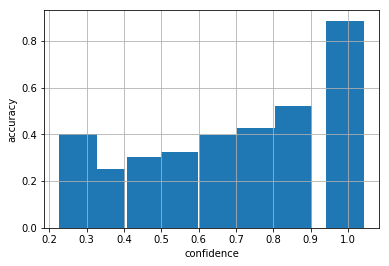

In [0]:
vgg_predictions = vgg.predict(x_test)
plot_discrepancy(vgg_predictions, y_test)

In [0]:
print("Predictions shape: ", pred.shape)
print("softmax output for first test samples: \n", pred[0])

Predictions shape:  (10000, 10)
softmax output for first test samples: 
 [2.1020765e-06 5.7894169e-05 1.5895067e-06 9.9923861e-01 1.6379404e-08
 3.1021945e-04 6.8256741e-05 1.7916864e-05 1.9540475e-06 3.0148731e-04]


In [0]:
pred_idx = np.argmax(pred, axis=1)
max_conf = np.max(pred, axis=1)
print(pred_idx.shape, max_conf.shape)
print(np.min(max_conf), np.max(max_conf))

(10000,) (10000,)
0.24877599 1.0


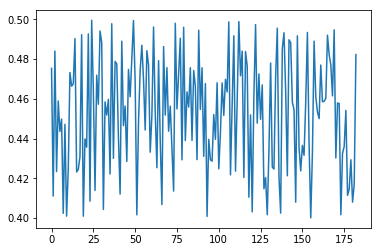

In [0]:
# check
plt.plot(max_pred[np.argwhere((max_pred > 0.4) &(max_pred  < 0.5))])

In [0]:
diff = pred_idx - y_test.flatten()
indices = np.argwhere((max_pred > (0.2)) &(max_pred  < (0.3))).flatten()
print(indices)
print(pred_idx[indices])
print(y_test.flatten()[indices])
print(diff[indices])
print(len(np.argwhere(diff[indices] == 0)))
print(len(np.argwhere(diff == 0)))

[ 366  376 1493 1736 2136 2232 2804 2840 3263 3391 3789 4190 5166 5517
 5869 6574 6729 6859 6904 6997 8006 9114]
[9 9 9 2 9 0 7 6 9 9 7 5 0 1 7 4 0 3 5 2 9 0]
[1 0 1 5 0 0 3 3 1 3 9 3 9 1 7 0 0 3 5 8 9 8]
[ 8  9  8 -3  9  0  4  3  8  6 -2  2 -9  0  0  4  0  0  0 -6  0 -8]
7
8072


In [0]:
# create 10 bins
hist = []
indicies_sum = 0
for i in range(0,10):
    print("Calculating predictions within confidence range {} - {}".format((i*0.1), ((i+1)*0.1)))
    # indices for the max softmax that lies within certain range
    indices = np.argwhere((max_pred >= (i*0.1)) &(max_pred  <= (0.1*(i+1)))).flatten()
    indicies_sum += len(indices)
    correct_predictions = np.argwhere(np.argwhere(diff[indices] == 0))
    print("Number of correct predictions for the specified confidence range", len(correct_predictions))
    hist.append(len(correct_predictions))

Calculating predictions within confidence range 0.0 - 0.1
Number of correct predictions for the specified confidence range 0
Calculating predictions within confidence range 0.1 - 0.2
Number of correct predictions for the specified confidence range 0
Calculating predictions within confidence range 0.2 - 0.30000000000000004
Number of correct predictions for the specified confidence range 7
Calculating predictions within confidence range 0.30000000000000004 - 0.4
Number of correct predictions for the specified confidence range 26
Calculating predictions within confidence range 0.4 - 0.5
Number of correct predictions for the specified confidence range 65
Calculating predictions within confidence range 0.5 - 0.6000000000000001
Number of correct predictions for the specified confidence range 98
Calculating predictions within confidence range 0.6000000000000001 - 0.7000000000000001
Number of correct predictions for the specified confidence range 140
Calculating predictions within confidence r

In [0]:
a = np.array([2,2])
b = np.array([3,0])
print(np.linalg.norm(a,2))
print(np.linalg.norm(b,2))
print(np.linalg.norm(b,2) * np.linalg.norm(a,2) * np.cos(np.deg2rad(45)))
print(np.matmul(a, b))

2.8284271247461903
3.0
6.000000000000001
6
